<a href="https://colab.research.google.com/github/LIYunzhe1408/Flow-Matching/blob/main/cs180_proj5b_flowmatching_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5B: Flow Matching from Scratch!

## Setup environment

In [1]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [2]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch
import torch.nn.functional as F

# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

UNet covers both semantic concepts and specific details. When downsampling, we are going deep into the high-level concept, while upsampling is converting abstract concept back to image with high resolution. When up sampling, previous downsampled features will be concatenated together to cover both details(edge from downsampling) and semantic(from upsampling)

In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.conv(x)))


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.conv(x)))

class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.upconv(x)))


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=7)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.pool(x)).view(x.size(0), -1)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=7, stride=7, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1, 1, 1)
        return self.activate(self.bn(self.convTrans(x)))

In [4]:

# Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        return self.conv2(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downConv = DownConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downConv(x)
        return self.conv_block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = UpConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)
        return self.conv_block(x)

## Implementing Unconditional UNet

In [5]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.initial_conv = ConvBlock(in_channels, num_hiddens)

        self.down1 = DownBlock(num_hiddens, num_hiddens)  # 28x28 -> 14x14
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)  # 14x14 -> 7x7

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2, num_hiddens * 2)

        self.up2 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up1 = UpBlock(num_hiddens * 2, num_hiddens)
        self.last_to_second = ConvBlock(num_hiddens * 2, num_hiddens)
        self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x_init = self.initial_conv(x)  # (B, num_hiddens, 28, 28)
        # print("x_init: ", x_init.shape)
        x1 = self.down1(x_init)  # (B, num_hiddens*2, 14, 14)
        # print("x_1: ", x1.shape)
        x2 = self.down2(x1)  # (B, num_hiddens*4, 7, 7)
        # print("x_2: ", x2.shape)

        latent = self.flatten(x2)  # (B, num_hiddens*4, 1, 1)
        # print("latent_flattened: ", latent.shape)
        latent = self.unflatten(latent)  # (B, num_hiddens*4, 7, 7)
        # print("latent_unflattened: ", latent.shape)

        con = torch.cat([latent, x2], dim=1)  # Concatenation with downsampled feature map
        # print("x_2 concat unflatten: ", con.shape)
        x = self.up2(con)  # (B, num_hiddens*2, 14, 14)
        # print("Upblock2: ", x.shape)


        con = torch.cat([x, x1], dim=1)  # Concatenation with initial feature map
        # print("x_1 concat upblock2: ", con.shape)
        x = self.up1(con)  # (B, num_hiddens, 28, 28)
        # print(x.shape)


        con = torch.cat([x, x_init], dim=1)  # Concatenation with initial feature map
        # print("x_init concat upblock1: ", con.shape)
        x = self.last_to_second(con)  # (B, num_hiddens, 28, 28)
        # print("Second to last: ", x.shape)
        x = self.final_conv(x)  # Final convolution
        # print("Output: ", x.shape)

        return x

In [6]:
model = UnconditionalUNet(in_channels=1, num_hiddens=128)
sample_input = torch.randn(1, 1, 28, 28)  # Batch size 1, grayscale image
output = model(sample_input)
print(output.shape)  # Expected output: (1, 1, 28, 28)

torch.Size([1, 1, 28, 28])


In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Visualize the noising process using $\sigma$=[0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load the MNIST dataset
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
print(mnist)

# Select some sample images to display
num_samples = 5  # Number of images to visualize
sample_indices = [0, 1, 2, 3, 4]  # Manually chosen indices for visualization
sample_images = [mnist[i][0] for i in sample_indices]  # Extract images


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.27MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
# Define different noise levels (σ values)
noise_levels = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

# Function to add Gaussian noise
def add_noise(image, noise_std):
    noise = noise_std * torch.randn_like(image)  # Generate Gaussian noise
    noisy_image = (image + noise)
    return noisy_image


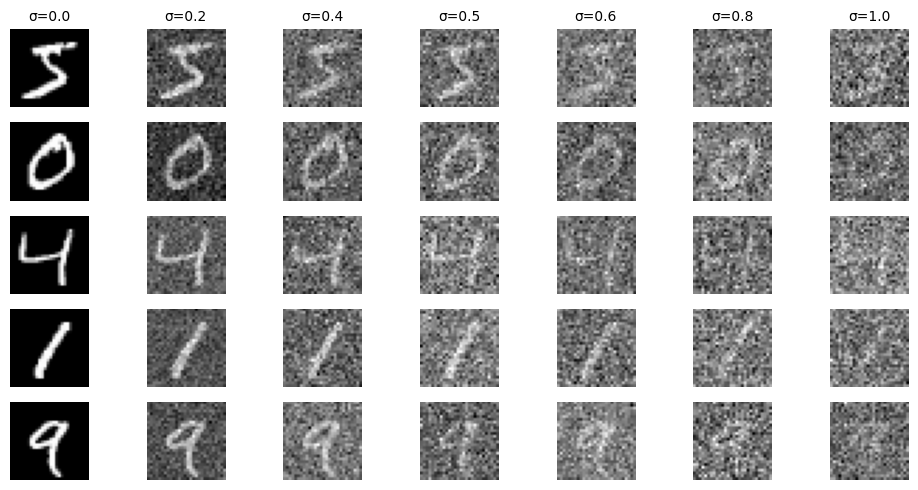

In [ ]:
# Create figure
fig, axes = plt.subplots(num_samples, len(noise_levels), figsize=(10, 5))

# Plot images for each noise level
for row, img in enumerate(sample_images):
    for col, sigma in enumerate(noise_levels):
        noisy_img = add_noise(img, sigma)  # Apply noise
        axes[row, col].imshow(noisy_img.squeeze(0), cmap="gray")  # Show image
        axes[row, col].axis("off")

        # Add noise level labels on top row
        if row == 0:
            axes[row, col].set_title(f"σ={sigma}", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Define dataset transformation (normalize and add noise dynamically)
class NoisyMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, train=True, noise_std=0.5):
        self.dataset = datasets.MNIST(root="./data", train=train, download=True, transform=transforms.ToTensor())
        self.noise_std = noise_std  # Standard deviation of noise

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]  # Get clean image
        z = add_noise(x, self.noise_std)
        return z, x  # Noisy image (z), clean image (x)

# Load dataset
batch_size = 256
train_loader = DataLoader(NoisyMNISTDataset(train=True, noise_std=0.5), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(NoisyMNISTDataset(train=False, noise_std=0.5), batch_size=batch_size, shuffle=False)


In [ ]:
# Define loss function (L2 Loss)
criterion = nn.MSELoss()

# Initialize model and optimizer
model = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import torch
import os

num_epochs = 5
train_losses = []
save_epochs = [1, 5]  # Save model at these epochs

# Define checkpoint directory
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0

    for step, (z, x) in enumerate(train_loader):
        z, x = z.to(device), x.to(device)

        optimizer.zero_grad()
        x_pred = model(z)
        loss = criterion(x_pred, x)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_losses.append(loss.item())

        if step % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{step}/{len(train_loader)}], Loss: {loss.item():.6f}")

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Avg Loss: {avg_loss:.6f}")

    # **Save model checkpoint at specified epochs**
    if epoch in save_epochs:
        checkpoint_path = os.path.join(checkpoint_dir, f"unet_epoch_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")


Epoch [1/5], Step [0/235], Loss: 0.210524
Epoch [1/5], Step [100/235], Loss: 0.014773
Epoch [1/5], Step [200/235], Loss: 0.012587
Epoch [1/5], Avg Loss: 0.021405
Checkpoint saved: ./checkpoints/unet_epoch_1.pth
Epoch [2/5], Step [0/235], Loss: 0.011850
Epoch [2/5], Step [100/235], Loss: 0.011244
Epoch [2/5], Step [200/235], Loss: 0.010290
Epoch [2/5], Avg Loss: 0.011000
Epoch [3/5], Step [0/235], Loss: 0.009720
Epoch [3/5], Step [100/235], Loss: 0.009533
Epoch [3/5], Step [200/235], Loss: 0.009190
Epoch [3/5], Avg Loss: 0.009464
Epoch [4/5], Step [0/235], Loss: 0.008866
Epoch [4/5], Step [100/235], Loss: 0.008575
Epoch [4/5], Step [200/235], Loss: 0.008124
Epoch [4/5], Avg Loss: 0.008758
Epoch [5/5], Step [0/235], Loss: 0.008717
Epoch [5/5], Step [100/235], Loss: 0.008574
Epoch [5/5], Step [200/235], Loss: 0.008486
Epoch [5/5], Avg Loss: 0.008342
Checkpoint saved: ./checkpoints/unet_epoch_5.pth


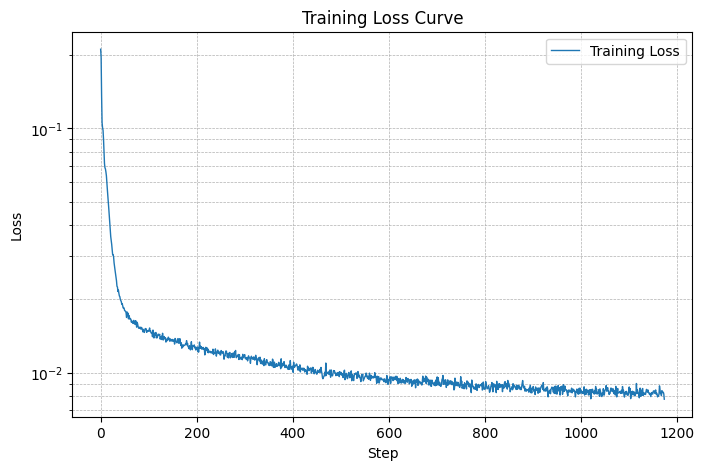

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", linewidth=1)
plt.yscale("log")  # Log scale for better visualization
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

<ipython-input-21-11e5af2d5627>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Loaded model from ./checkpoints/unet_epoch_1.pth


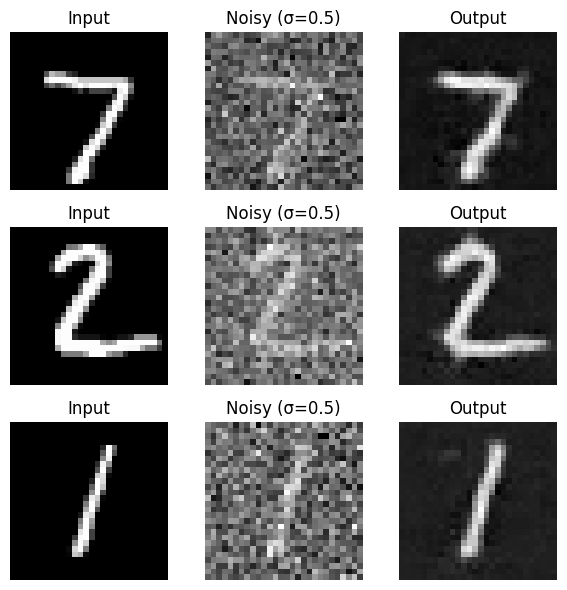

Figure: Results on digits after 1 epoch(s) of training
Loaded model from ./checkpoints/unet_epoch_5.pth


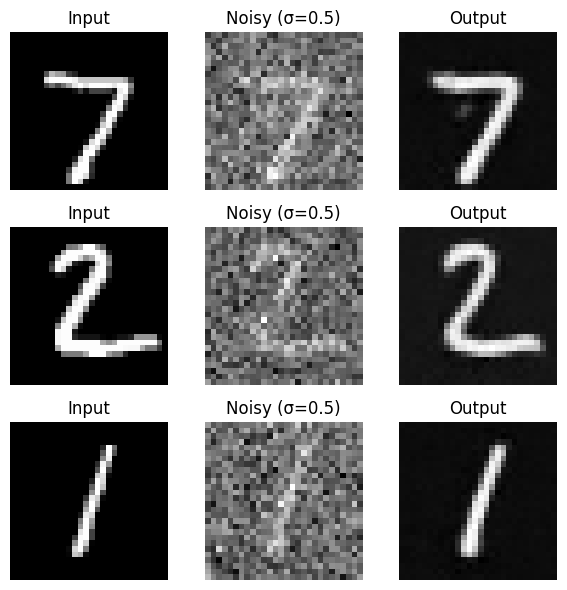

Figure: Results on digits after 5 epoch(s) of training


In [ ]:
import matplotlib.pyplot as plt

# Function to load model checkpoint
def load_checkpoint(model, epoch):
    checkpoint_path = f"./checkpoints/unet_epoch_{epoch}.pth"
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    print(f"Loaded model from {checkpoint_path}")
    return model

# Function to visualize inference results
def visualize_denoising(model, epoch):
    model.eval()
    test_loader = DataLoader(NoisyMNISTDataset(train=False, noise_std=0.5), batch_size=3, shuffle=False) # Changed batch_size to 3

    with torch.no_grad():
        for z, x in test_loader:
            z, x = z.to(device), x.to(device)
            x_pred = model(z)
            break

    z = z.cpu().numpy()
    x_pred = x_pred.cpu().numpy()
    x = x.cpu().numpy()

    fig, axes = plt.subplots(3, 3, figsize=(6, 6))

    for i in range(3):  # Show first 3 samples
        axes[i, 0].imshow(x[i, 0], cmap="gray")
        axes[i, 0].set_title("Input")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(z[i, 0], cmap="gray")
        axes[i, 1].set_title(f"Noisy (σ=0.5)")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(x_pred[i, 0], cmap="gray")
        axes[i, 2].set_title("Output")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()
    print(f"Figure: Results on digits after {epoch} epoch(s) of training")

# **Run inference for epoch 1 and 5**
for epoch in save_epochs:
    model = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)  # Re-initialize model
    model = load_checkpoint(model, epoch)
    visualize_denoising(model, epoch)

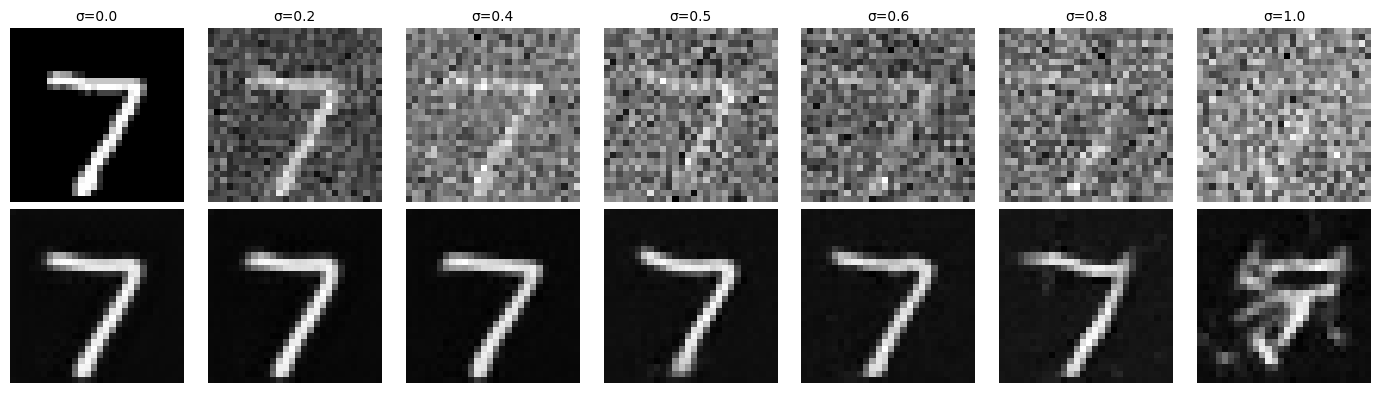

In [ ]:
# Define noise levels to visualize
noise_levels = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

# Get a batch of test images with multiple noise levels
# Iterate through each noise level and create a separate DataLoader
test_loaders = [DataLoader(NoisyMNISTDataset(train=False, noise_std=sigma), batch_size=1, shuffle=False)
               for sigma in noise_levels]

# Get one test image with multiple noise versions
model.eval()
with torch.no_grad():
    # Iterate through each DataLoader to get images with different noise levels

    all_z = [] # Initialize as list
    all_x_pred = [] # Initialize as list
    all_x = [] # Initialize as list

    for i, test_loader in enumerate(test_loaders):
        for z, x in test_loader:  # (noisy_images, clean_image, label)
            z, x = z.to(device), x.to(device)
            x_pred = model(z)  # Denoised output

            # Append data to lists
            all_z.append(z.cpu().numpy())
            all_x_pred.append(x_pred.cpu().numpy())
            all_x.append(x.cpu().numpy())

            break# Take only one batch for visualization

    # Convert lists to numpy arrays
    all_z = np.concatenate(all_z, axis=0)
    all_x_pred = np.concatenate(all_x_pred, axis=0)
    all_x = np.concatenate(all_x, axis=0)

# Convert to numpy for visualization
z = all_z  # Shape: (num_noise_levels, 1, 28, 28)
x_pred = all_x_pred
x = all_x

# Create figure with subplots (2 rows: noisy input & denoised output)
fig, axes = plt.subplots(2, len(noise_levels), figsize=(14, 4))

# Loop through different noise levels
for i in range(len(noise_levels)):
    # Noisy input (Top row)
    axes[0, i].imshow(z[i, 0], cmap="gray")
    axes[0, i].set_title(f"σ={noise_levels[i]}", fontsize=10)
    axes[0, i].axis("off")

    # Denoised output (Bottom row)
    axes[1, i].imshow(x_pred[i, 0], cmap="gray")
    axes[1, i].axis("off")

# Add row labels
axes[0, 0].set_ylabel("Noisy Image", fontsize=12)
axes[1, 0].set_ylabel("Denoised Output", fontsize=12)

plt.tight_layout()
plt.show()

## Denoise with pure Noise

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Dataset for denoising pure noise
class PureNoiseDataset(torch.utils.data.Dataset):
    def __init__(self, size=60000, image_size=(1, 28, 28)):  # Same size as MNIST
        self.size = size
        self.image_size = image_size  # (Channels, Height, Width)

    def __len__(self):
        return self.size  # Same size as MNIST for consistency

    def __getitem__(self, idx):
        noise = torch.randn(self.image_size)  # Generate Gaussian noise
        return noise, noise  # Input and "clean" target are both noise

# Load dataset
batch_size = 256
train_loader = DataLoader(PureNoiseDataset(), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(PureNoiseDataset(size=10000), batch_size=batch_size, shuffle=False)


In [ ]:
import os

num_epochs = 5
train_losses = []
save_epochs = [1, 5]  # Save model at these epochs

# Define checkpoint directory
checkpoint_dir = "./checkpoints_pure_noise"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0

    for step, (z, _) in enumerate(train_loader):  # No ground truth images, only noise
        z = z.to(device)

        optimizer.zero_grad()
        x_pred = model(z)
        loss = criterion(x_pred, z)  # Loss between denoised output and noise
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_losses.append(loss.item())

        if step % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{step}/{len(train_loader)}], Loss: {loss.item():.6f}")

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Avg Loss: {avg_loss:.6f}")

    # Save model checkpoint at specified epochs
    if epoch in save_epochs:
        checkpoint_path = os.path.join(checkpoint_dir, f"unet_epoch_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

Epoch [1/5], Step [0/235], Loss: 1.098472
Epoch [1/5], Step [100/235], Loss: 0.011306
Epoch [1/5], Step [200/235], Loss: 0.005749
Epoch [1/5], Avg Loss: 0.033473
Checkpoint saved: ./checkpoints_pure_noise/unet_epoch_1.pth
Epoch [2/5], Step [0/235], Loss: 0.004872
Epoch [2/5], Step [100/235], Loss: 0.003548
Epoch [2/5], Step [200/235], Loss: 0.002634
Epoch [2/5], Avg Loss: 0.003422
Epoch [3/5], Step [0/235], Loss: 0.002433
Epoch [3/5], Step [100/235], Loss: 0.001912
Epoch [3/5], Step [200/235], Loss: 0.001710
Epoch [3/5], Avg Loss: 0.001955
Epoch [4/5], Step [0/235], Loss: 0.001535
Epoch [4/5], Step [100/235], Loss: 0.001280
Epoch [4/5], Step [200/235], Loss: 0.001179
Epoch [4/5], Avg Loss: 0.001320
Epoch [5/5], Step [0/235], Loss: 0.001108
Epoch [5/5], Step [100/235], Loss: 0.001054
Epoch [5/5], Step [200/235], Loss: 0.000943
Epoch [5/5], Avg Loss: 0.000999
Checkpoint saved: ./checkpoints_pure_noise/unet_epoch_5.pth


<ipython-input-27-076867b79d44>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Loaded model from ./checkpoints_pure_noise/unet_epoch_1.pth


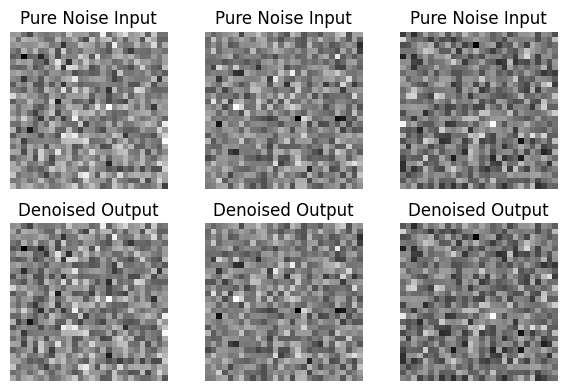

Figure: Denoising pure noise after 1 epoch(s)
Loaded model from ./checkpoints_pure_noise/unet_epoch_5.pth


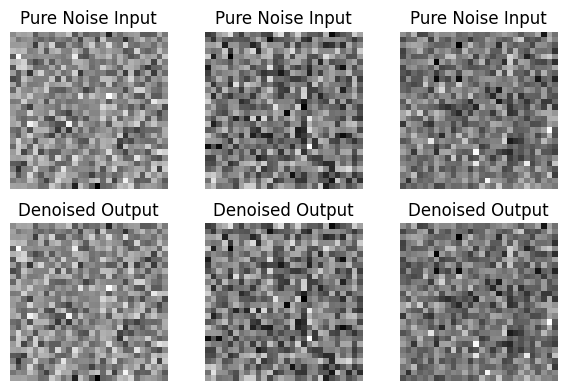

Figure: Denoising pure noise after 5 epoch(s)


In [ ]:
import matplotlib.pyplot as plt

# Function to load model checkpoint
def load_checkpoint(model, epoch):
    checkpoint_path = f"./checkpoints_pure_noise/unet_epoch_{epoch}.pth"
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    print(f"Loaded model from {checkpoint_path}")
    return model

def visualize_pure_noise_denoising(model, epoch):
    model.eval()
    # Change batch_size to 3 to load 3 images
    test_loader = DataLoader(PureNoiseDataset(size=3), batch_size=3, shuffle=False)

    with torch.no_grad():
        for z, _ in test_loader:
            z = z.to(device)
            x_pred = model(z)  # Denoised output
            break  # Take only one batch

    z = z.cpu().numpy()
    x_pred = x_pred.cpu().numpy()

    fig, axes = plt.subplots(2, 3, figsize=(6, 4))

    for i in range(3):  # Show first 3 samples
        axes[0, i].imshow(z[i, 0], cmap="gray")
        axes[0, i].set_title(f"Pure Noise Input")
        axes[0, i].axis("off")

        axes[1, i].imshow(x_pred[i, 0], cmap="gray")
        axes[1, i].set_title(f"Denoised Output")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()
    print(f"Figure: Denoising pure noise after {epoch} epoch(s)")

# **Run inference for epoch 1 and 5**
for epoch in save_epochs:
    model = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)  # Re-initialize model
    model = load_checkpoint(model, epoch)
    visualize_pure_noise_denoising(model, epoch)

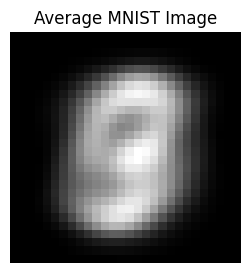

In [ ]:
import numpy as np

# Compute average MNIST image
mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
mnist_images = torch.stack([mnist_dataset[i][0] for i in range(len(mnist_dataset))])  # Stack all images
average_mnist = mnist_images.mean(dim=0)  # Compute mean image

# Plot average MNIST image
plt.figure(figsize=(3, 3))
plt.imshow(average_mnist.squeeze(0), cmap="gray")
plt.title("Average MNIST Image")
plt.axis("off")
plt.show()

# Part 2: Flow Matching

## Implementing a Time-conditioned UNet

In [95]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc = nn.Linear(in_channels, out_channels)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.act(self.fc(x)))


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.initial_conv = ConvBlock(in_channels, num_hiddens)

        self.down1 = DownBlock(num_hiddens, num_hiddens)  # 28x28 -> 14x14
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)  # 14x14 -> 7x7

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2, num_hiddens * 2)

        self.up2 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up1 = UpBlock(num_hiddens * 2, num_hiddens)
        self.fc1_t = FCBlock(1, num_hiddens*2)
        self.fc2_t = FCBlock(1, num_hiddens)
        self.last_to_second = ConvBlock(num_hiddens * 2, num_hiddens)
        self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x_init = self.initial_conv(x)  # (B, num_hiddens, 28, 28)
        # print("x_init: ", x_init.shape)
        x1 = self.down1(x_init)  # (B, num_hiddens*2, 14, 14)
        # print("x_1: ", x1.shape)
        x2 = self.down2(x1)  # (B, num_hiddens*4, 7, 7)
        # print("x_2: ", x2.shape)

        # Latent layer
        latent = self.flatten(x2)  # (B, num_hiddens*4, 1, 1)
        # print("latent_flattened: ", latent.shape)
        latent = self.unflatten(latent)  # (B, num_hiddens*4, 7, 7)
        # print("latent_unflattened: ", latent.shape)

        t1 = self.fc1_t(t)  # (B, num_hiddens)
        t2 = self.fc2_t(t)  # (B, num_hiddens)
        t1 = t1[:, :, None, None]  # Reshape to match feature map dimensions
        t2 = t2[:, :, None, None]
        latent = latent * t1

        con = torch.cat([latent, x2], dim=1)  # Concatenation with downsampled feature map
        # print("x_2 concat unflatten: ", con.shape)
        x = self.up2(con)  # (B, num_hiddens*2, 14, 14)
        # print("Upblock2: ", x.shape)

        x = x * t2

        con = torch.cat([x, x1], dim=1)  # Concatenation with initial feature map
        # print("x_1 concat upblock2: ", con.shape)
        x = self.up1(con)  # (B, num_hiddens, 28, 28)
        # print(x.shape)


        con = torch.cat([x, x_init], dim=1)  # Concatenation with initial feature map
        # print("x_init concat upblock1: ", con.shape)
        x = self.last_to_second(con)  # (B, num_hiddens, 28, 28)
        # print("Second to last: ", x.shape)
        x = self.final_conv(x)  # Final convolution
        # print("Output: ", x.shape)

        return x

## Test Time-Conditional UNet architecture

In [96]:
model = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64)
sample_input = torch.randn(1, 1, 28, 28)  # Batch size 1, grayscale image
t = torch.tensor([0.5], dtype=torch.float32)  # Example time conditioning at mid-point
t = t.view(1, -1)  # Reshape to (batch_size, 1)
output = model(sample_input, t)
print(output.shape)  # Expected output: (1, 1, 28, 28)

torch.Size([1, 1, 28, 28])


## Load Dataset

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# Define dataset with on-the-fly noise application
class NoisyMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.dataset = datasets.MNIST(root="./data", train=train, download=True, transform=transforms.ToTensor())

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x_1, _ = self.dataset[idx]  # Step 2: Get clean image
        return x_1


# Load dataset
batch_size = 64
train_loader = DataLoader(NoisyMNISTDataset(train=True), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(NoisyMNISTDataset(train=False), batch_size=batch_size, shuffle=False)

In [98]:
def fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """

    unet.train()
    # Sample a random timestep t ~ U(0,1)
    # t = torch.rand(1, device=x_1.device) # Original code
    t = torch.rand(x_1.shape[0], 1, device=x_1.device) # Reshape t to (batch_size, 1)

    # Sample Gaussian noise x_0 ~ N(0, I)
    x_0 = torch.randn_like(x_1, device=x_1.device)

    # Compute noisy image x_t = (1 - t) * x_0 + t * x_1
    # Reshape t to have the same number of dimensions as x_0 and x_1
    t = t[:, :, None, None]  # Add two extra dimensions for height and width
    x_t = (1 - t) * x_0 + t * x_1

    x_pred = unet(x_t, t.squeeze(dim=(2,3)))  # Step 6: Model predicts (x1 - x0), remove extra dims from t

    # Correct loss function
    loss = nn.MSELoss()(x_pred, x_1 - x_0)
    return loss

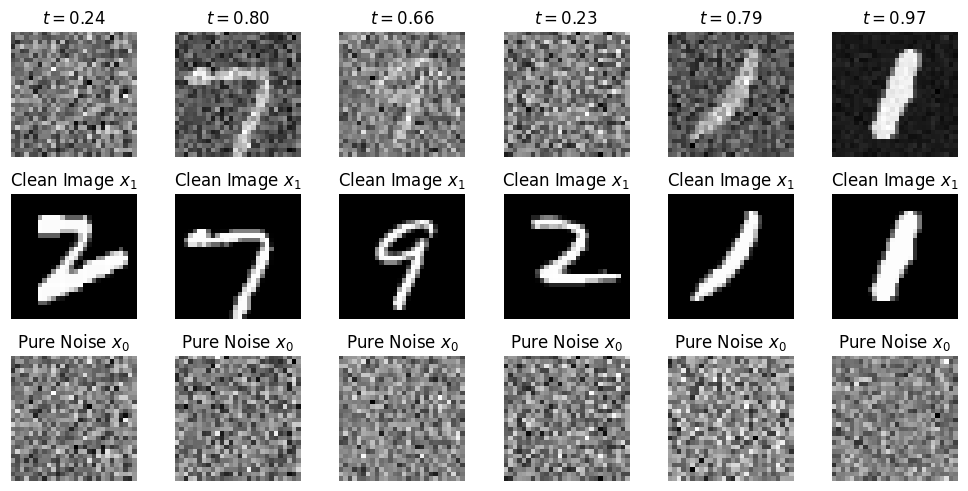

In [99]:
import matplotlib.pyplot as plt
import torch

# Get a batch of training samples
train_iter = iter(train_loader)
x_1_batch = next(train_iter)  # Clean images (x_1)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_1_batch = x_1_batch.to(device)

# Sample random timestep t
t_batch = torch.rand((x_1_batch.size(0), 1), device=device)  # Uniform(0,1)

# Generate pure Gaussian noise
x_0_batch = torch.randn_like(x_1_batch)  # Sample from N(0, I)

# Compute noisy image at timestep t
# Reshape t_batch to have the same number of dimensions as x_0_batch and x_1_batch
t_batch = t_batch[:, :, None, None]  # Add two extra dimensions for height and width

x_t_batch = (1 - t_batch) * x_0_batch + t_batch * x_1_batch  # Apply noise

# Convert tensors to numpy for plotting
x_t_batch = x_t_batch[:6].cpu().numpy()  # Noisy input (x_t)
x_0_batch = x_0_batch[:6].cpu().numpy()  # Pure noise (x_0)
t_batch = t_batch[:6].cpu().numpy().flatten()  # Extract scalar t values
x_1_batch = x_1_batch[:6].cpu().numpy()  # Clean images (x_1)

# Plot xt vs. x0
fig, axes = plt.subplots(3, 6, figsize=(10, 5))

for i in range(6):
    # Noisy image at timestep t (x_t)
    axes[0, i].imshow(x_t_batch[i, 0], cmap="gray")
    axes[0, i].set_title(f"$t={t_batch[i]:.2f}$")
    axes[0, i].axis("off")

    # Clean image (x_1)
    axes[1, i].imshow(x_1_batch[i, 0], cmap="gray")
    axes[1, i].set_title(f"Clean Image $x_1$")
    axes[1, i].axis("off")

    # Pure noise (x_0)
    axes[2, i].imshow(x_0_batch[i, 0], cmap="gray")
    axes[2, i].set_title(f"Pure Noise $x_0$")
    axes[2, i].axis("off")

# Set row labels
axes[0, 0].set_ylabel("$x_t$ (Noisy Image)", fontsize=12)
axes[1, 0].set_ylabel("$x_1$ (Clean Image)", fontsize=12)
axes[2, 0].set_ylabel("$x_0$ (Pure Noise)", fontsize=12)

plt.tight_layout()
plt.show()

In [134]:
@torch.inference_mode()
def fm__sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    torch.manual_seed(seed)  # Set random seed for consistency

    # Step 2: Initialize `x_t` with Gaussian noise
    N, C = 36, 1  # 36 samples, single-channel (grayscale)
    x_t = torch.randn((N, C, img_wh[0], img_wh[1]), device=next(unet.parameters()).device)

    # Step 3: Define timesteps
    timesteps = torch.linspace(1.0, 0.0, steps=num_ts, device=x_t.device)

    # Step 4: Iteratively refine `x_t`
    for t in timesteps:
        t_tensor = torch.full((N, 1), t.item(), device=x_t.device)  # Broadcast timestep
        x_t = x_t + (1 / num_ts) * unet(x_t, t_tensor)  # Refinement step
    # x_t = x_t.clamp(0, 1)  # Ensure pixel values are within range
    return x_t

## Training infra

In [135]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return fm_forward(
            self.unet, x, self.num_ts
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return fm__sample(
            self.unet, img_wh, self.num_ts, seed
        )


In [136]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
flow_matching = FlowMatching(model, num_ts=100)  # Wrap UNet in FlowMatching

# Loss and optimizer
criterion = nn.MSELoss()
# Optimizer and LR scheduler
num_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**(1/num_epochs))  # Exponential decay


## Training

In [102]:
# Training loop
train_losses = []
checkpoint_dir = "./checkpoints_time_unet"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0

    for step, x_1 in enumerate(train_loader):
        x_1 = x_1.to(device)

        optimizer.zero_grad()

        loss = flow_matching(x_1)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_losses.append(loss.item())

        if step % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{step}/{len(train_loader)}], Loss: {loss.item():.6f}")

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Avg Loss: {avg_loss:.6f}")


    # Step learning rate scheduler
    scheduler.step()

    # Save checkpoint
    if epoch % 5 == 0 or epoch == 1:
      checkpoint_path = os.path.join(checkpoint_dir, f"unet_epoch_{epoch}.pth")
      torch.save(model.state_dict(), checkpoint_path)
      print(f"Checkpoint saved: {checkpoint_path}")

Epoch [1/20], Step [0/938], Loss: 1.216682
Epoch [1/20], Step [100/938], Loss: 0.217886
Epoch [1/20], Step [200/938], Loss: 0.210741
Epoch [1/20], Step [300/938], Loss: 0.146486
Epoch [1/20], Step [400/938], Loss: 0.145028
Epoch [1/20], Step [500/938], Loss: 0.152488
Epoch [1/20], Step [600/938], Loss: 0.157691
Epoch [1/20], Step [700/938], Loss: 0.133475
Epoch [1/20], Step [800/938], Loss: 0.156476
Epoch [1/20], Step [900/938], Loss: 0.148403
Epoch [1/20], Avg Loss: 0.187240
Checkpoint saved: ./checkpoints_time_unet/unet_epoch_1.pth
Epoch [2/20], Step [0/938], Loss: 0.134900
Epoch [2/20], Step [100/938], Loss: 0.122733
Epoch [2/20], Step [200/938], Loss: 0.143284
Epoch [2/20], Step [300/938], Loss: 0.125730
Epoch [2/20], Step [400/938], Loss: 0.116231
Epoch [2/20], Step [500/938], Loss: 0.133136
Epoch [2/20], Step [600/938], Loss: 0.143603
Epoch [2/20], Step [700/938], Loss: 0.112898
Epoch [2/20], Step [800/938], Loss: 0.115527
Epoch [2/20], Step [900/938], Loss: 0.115465
Epoch [2/20]

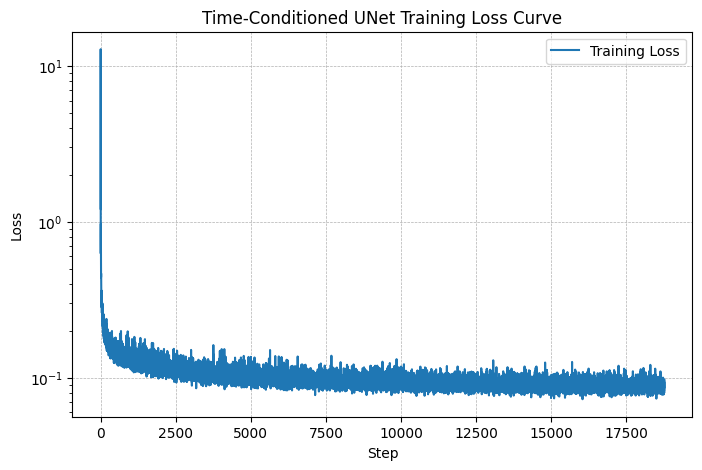

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", linewidth=1.5)
plt.yscale("log")  # Use log scale for better visualization
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Time-Conditioned UNet Training Loss Curve")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

## Implementing the Forward and Reverse Process for Time-conditioned Denoising

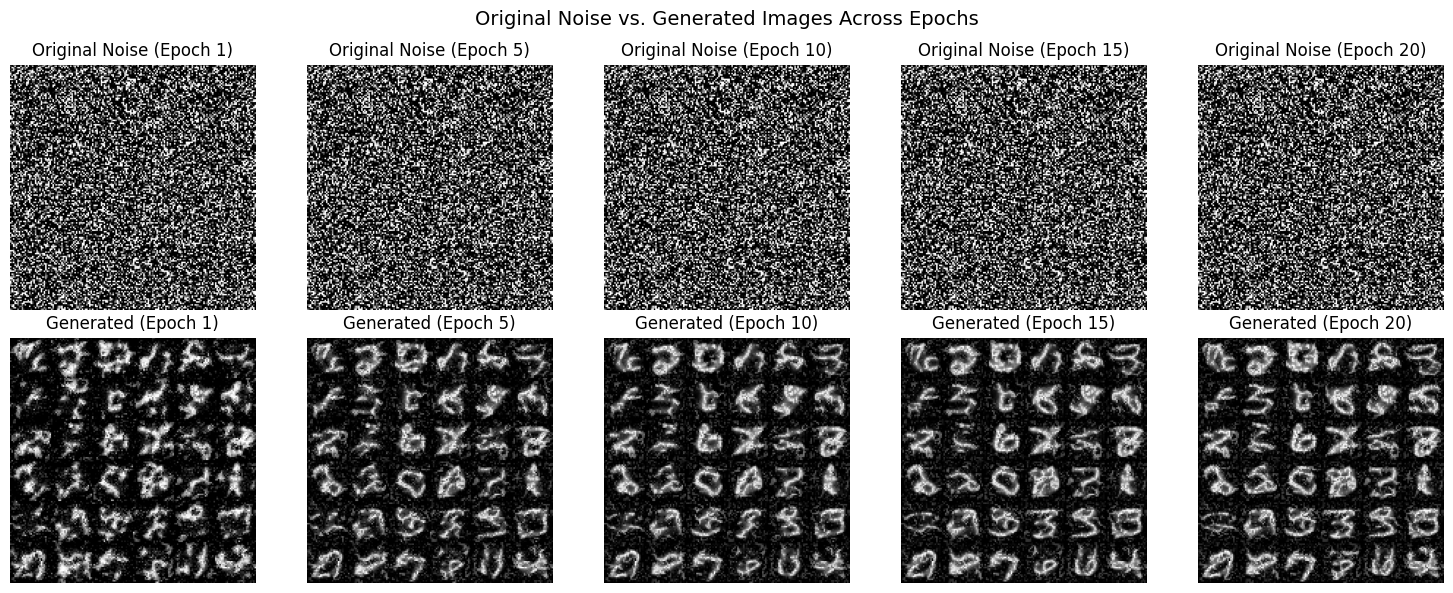

In [149]:
epochs_to_plot = [1, 5, 10, 15, 20]  # Epochs to visualize
num_samples = 36  # Number of images per epoch

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
flow_matching = FlowMatching(unet, num_ts=100)  # Wrap UNet in FlowMatching

# Generate pure Gaussian noise
torch.manual_seed(2)
x_0 = torch.randn((num_samples, 1, 28, 28), device=device).cpu().numpy()

num_rows = 2
num_cols = len(epochs_to_plot)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Original Noise (same for all epochs)
for i in range(num_cols):
    grid_noise = np.vstack([np.hstack(x_0[j * 6:(j + 1) * 6, 0]) for j in range(6)])  # Arrange noise in a grid
    axes[0, i].imshow(grid_noise, cmap="gray", vmin=0, vmax=1)
    axes[0, i].set_title(f"Original Noise (Epoch {epochs_to_plot[i]})")
    axes[0, i].axis("off")

# Generated Images at Different Epochs
for i, epoch in enumerate(epochs_to_plot):
    checkpoint_path = os.path.join("./checkpoints_time_unet", f"unet_epoch_{epoch}.pth")

    unet.load_state_dict(torch.load(checkpoint_path, map_location=device))
    unet.eval()

    generated_images = flow_matching.sample(img_wh=(28, 28), seed=2).cpu().numpy()

    # Arrange generated images in a grid
    grid_image = np.vstack([np.hstack(generated_images[j * 6:(j + 1) * 6, 0]) for j in range(6)])
    axes[1, i].imshow(grid_image, cmap="gray", vmin=0, vmax=1)
    axes[1, i].set_title(f"Generated (Epoch {epoch})")
    axes[1, i].axis("off")

fig.suptitle("Original Noise vs. Generated Images Across Epochs", fontsize=14)
plt.tight_layout()
plt.show()


### Implementing class-conditioned UNet

In [ ]:
# class ClassConditionalUNet(nn.Module):
#     def __init__(
#         self,
#         in_channels: int,
#         num_classes: int,
#         num_hiddens: int,
#     ):
#         super().__init__()

#     def forward(
#         self,
#         x: torch.Tensor,
#         c: torch.Tensor,
#         t: torch.Tensor,
#         mask: torch.Tensor | None = None,
#     ) -> torch.Tensor:
#         """
#         Args:
#             x: (N, C, H, W) input tensor.
#             c: (N,) int64 condition tensor.
#             t: (N,) normalized time tensor.
#             mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

#         Returns:
#             (N, C, H, W) output tensor.
#         """
#         assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
#         raise NotImplementedError()

In [10]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.initial_conv = ConvBlock(in_channels, num_hiddens)

        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2, num_hiddens * 2)

        self.up2 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up1 = UpBlock(num_hiddens * 2, num_hiddens)

        # Time and Class Conditioning
        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)
        self.fc1_c = FCBlock(num_classes, num_hiddens * 2)
        self.fc2_c = FCBlock(num_classes, num_hiddens)

        self.last_to_second = ConvBlock(num_hiddens * 2, num_hiddens)
        self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 class condition tensor (digit 0-9).
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        # Convert class indices to one-hot vectors
        c = F.one_hot(c, num_classes=10).float()

        # Apply dropout for unconditional training (p_uncond = 0.1)
        if mask is not None:
            c = c * mask[:, None]

        x_init = self.initial_conv(x)  # (B, num_hiddens, 28, 28)
        x1 = self.down1(x_init)  # (B, num_hiddens*2, 14, 14)
        x2 = self.down2(x1)  # (B, num_hiddens*4, 7, 7)

        # Latent processing
        latent = self.flatten(x2)  # (B, num_hiddens*4, 1, 1)
        latent = self.unflatten(latent)  # (B, num_hiddens*4, 7, 7)

        # Time & Class Conditioning
        t1 = self.fc1_t(t)[:, :, None, None]  # Reshape for broadcasting
        t2 = self.fc2_t(t)[:, :, None, None]
        c1 = self.fc1_c(c)[:, :, None, None]
        c2 = self.fc2_c(c)[:, :, None, None]

        # Apply conditioning
        latent = latent * c1 + t1  # Modulating unflatten with time & class
        con = torch.cat([latent, x2], dim=1)  # Skip connection
        x = self.up2(con)  # (B, num_hiddens*2, 14, 14)
        x = x * c2 + t2  # Modulating up1

        con = torch.cat([x, x1], dim=1)
        x = self.up1(con)

        con = torch.cat([x, x_init], dim=1)
        x = self.last_to_second(con)
        x = self.final_conv(x)

        return x


In [11]:
# def fm_forward(
#     unet: ClassConditionalUNet,
#     x_1: torch.Tensor,
#     c: torch.Tensor,
#     p_uncond: float,
#     num_ts: int,
# ) -> torch.Tensor:
#     """Algorithm 3

#     Args:
#         unet: ClassConditionalUNet
#         x_1: (N, C, H, W) input tensor.
#         c: (N,) int64 condition tensor.
#         p_uncond: float, probability of unconditioning the condition.
#         num_ts: int, number of timesteps.

#     Returns:
#         (,) loss.
#     """
#     unet.train()
#     # YOUR CODE HERE.
#     raise NotImplementedError()

In [12]:
import torch
import torch.optim as optim
import os

def fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """
    Algorithm 3: Class-Conditional Training

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) clean image.
        c: (N,) class condition tensor.
        p_uncond: float, probability of removing class conditioning.
        num_ts: int, number of timesteps.

    Returns:
        loss: (,) scalar tensor.
    """
    unet.train()

    # Step 3: Convert `c` into one-hot
    c_one_hot = F.one_hot(c, num_classes=10).float()

    # Step 4: With probability `p_uncond`, zero-out the class conditioning
    mask = (torch.rand(c.shape, device=c.device) > p_uncond).float()  # 0 for unconditional, 1 for conditioned
    c_one_hot = c_one_hot * mask[:, None]  # Apply the mask

    # Step 5: Sample a random timestep `t`
    t = torch.rand(x_1.shape[0], device=x_1.device, dtype=torch.float32)

    # Step 6: Sample pure noise `x_0`
    x_0 = torch.randn_like(x_1)

    # Step 7: Compute `x_t`
    x_t = (1 - t[:, None, None, None]) * x_0 + t[:, None, None, None] * x_1  # Broadcasting `t`

    # Step 8: Model prediction
    x_pred = unet(x_t, c, t, mask)

    # Compute loss
    loss = F.mse_loss(x_pred, x_1 - x_0)  # Predicting the difference (x1 - x0)

    return loss


In [13]:
# @torch.inference_mode()
# def fm_sample(
#     unet: ClassConditionalUNet,
#     c: torch.Tensor,
#     img_wh: tuple[int, int],
#     num_ts: int,
#     guidance_scale: float = 5.0,
#     seed: int = 0,
# ) -> torch.Tensor:
#     """Algorithm 4

#     Args:
#         unet: ClassConditionalUNet
#         c: (N,) int64 condition tensor. Only for class-conditional
#         img_wh: (H, W) output image width and height.
#         num_ts: int, number of timesteps.
#         guidance_scale: float, CFG scale.
#         seed: int, random seed.

#     Returns:
#         (N, C, H, W) final sample.
#         (N, T_animation, C, H, W) caches.
#     """
#     unet.eval()
#     # YOUR CODE HERE.
#     raise NotImplementedError()

In [30]:
@torch.inference_mode()
def fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4: Class-Conditional Sampling with CFG

    Args:
        unet: ClassConditionalUNet model.
        c: (N,) int64 condition tensor (class labels).
        img_wh: (H, W) output image size.
        num_ts: Number of timesteps.
        guidance_scale: Classifier-Free Guidance scale γ.
        seed: Random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    torch.manual_seed(seed)  # Fix random seed for reproducibility

    N, C = c.shape[0], 1  # Number of images, single-channel (grayscale)

    # Step 2: Initialize `x_t` with Gaussian noise
    x_t = torch.randn((N, C, img_wh[0], img_wh[1]), device=next(unet.parameters()).device)

    # Step 3: Define timesteps
    timesteps = torch.linspace(1.0, 0.0, steps=num_ts, device=x_t.device)

    # Step 4-8: Iterative refinement with Classifier-Free Guidance
    for t in timesteps:
        t_tensor = torch.full((N, 1), t.item(), device=x_t.device)  # Broadcast timestep

        # Compute both unconditional and conditional predictions
        u_uncond = unet(x_t, torch.zeros_like(c), t_tensor)  # Unconditional
        u_cond = unet(x_t, c, t_tensor)  # Conditional

        # Apply classifier-free guidance scaling
        u = u_uncond + guidance_scale * (u_cond - u_uncond)

        # Step update (Algorithm 4, Step 7)
        x_t = x_t + (1 / num_ts) * u

    return x_t.cpu()


In [31]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )

In [33]:
import torch

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)

# Generate a sample input (Batch size = 1, Grayscale image)
sample_input = torch.randn(1, 1, 28, 28).to(device)

# Example time conditioning at mid-point
t = torch.tensor([0.5], dtype=torch.float32, device=device).view(1, -1)  # Reshape to (batch_size, 1)

# Example class conditioning (One-hot vector for digit '3')
#c = torch.zeros(1, 10, device=device)  # Initialize zero-vector
#c[:, 3] = 1  # Set class '3' to 1
c = torch.tensor([3], dtype=torch.int64, device=device) #Changed to index of class instead of one-hot vector

# Run model
output = model(sample_input, c, t)

# Print output shape
print("Output shape:", output.shape)  # Expected output: (1, 1, 28, 28)

Output shape: torch.Size([1, 1, 28, 28])


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)

# Define Optimizer & Learning Rate Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 10))

In [61]:
# ------------------------------
# 3️⃣ Load Data
# ------------------------------
batch_size = 64
train_loader = DataLoader(NoisyMNISTDataset(train=True), batch_size=batch_size, shuffle=True)

# ------------------------------
# 4️⃣ Training Loop
# ------------------------------
train_losses = []
num_epochs = 10  # Total number of epochs
checkpoint_dir = "./checkpoints_class_unet"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0

    for step, (x_t, x_0, x_1, c, t) in enumerate(train_loader):
        x_t, x_0, x_1, c, t = x_t.to(device), x_0.to(device), x_1.to(device), c.to(device), t.to(device)

        optimizer.zero_grad()

        # Forward pass
        x_pred = model(x_t, c, t)  # Predict (x_1 - x_0)

        # Compute L2 loss
        loss = criterion(x_pred, x_1 - x_0)

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_losses.append(loss.item())
        if step % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{step}/{len(train_loader)}], Loss: {loss.item():.6f}")

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Avg Loss: {avg_loss:.6f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model checkpoints every 5 epochs
    if epoch % 5 == 0 or epoch == 2:
        checkpoint_path = os.path.join(checkpoint_dir, f"unet_epoch_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

print("Training Complete! ✅")


Epoch [1/10], Step [0/938], Loss: 1.420200
Epoch [1/10], Step [100/938], Loss: 0.201085
Epoch [1/10], Step [200/938], Loss: 0.180588
Epoch [1/10], Step [300/938], Loss: 0.169198
Epoch [1/10], Step [400/938], Loss: 0.133308
Epoch [1/10], Step [500/938], Loss: 0.127201
Epoch [1/10], Step [600/938], Loss: 0.131559
Epoch [1/10], Step [700/938], Loss: 0.125225
Epoch [1/10], Step [800/938], Loss: 0.123529
Epoch [1/10], Step [900/938], Loss: 0.126227
Epoch [1/10], Avg Loss: 0.190570
Epoch [2/10], Step [0/938], Loss: 0.120596
Epoch [2/10], Step [100/938], Loss: 0.114994
Epoch [2/10], Step [200/938], Loss: 0.112473
Epoch [2/10], Step [300/938], Loss: 0.136051
Epoch [2/10], Step [400/938], Loss: 0.105987
Epoch [2/10], Step [500/938], Loss: 0.108157
Epoch [2/10], Step [600/938], Loss: 0.102683
Epoch [2/10], Step [700/938], Loss: 0.126034
Epoch [2/10], Step [800/938], Loss: 0.105903
Epoch [2/10], Step [900/938], Loss: 0.106303
Epoch [2/10], Avg Loss: 0.119630
Checkpoint saved: ./checkpoints_class_

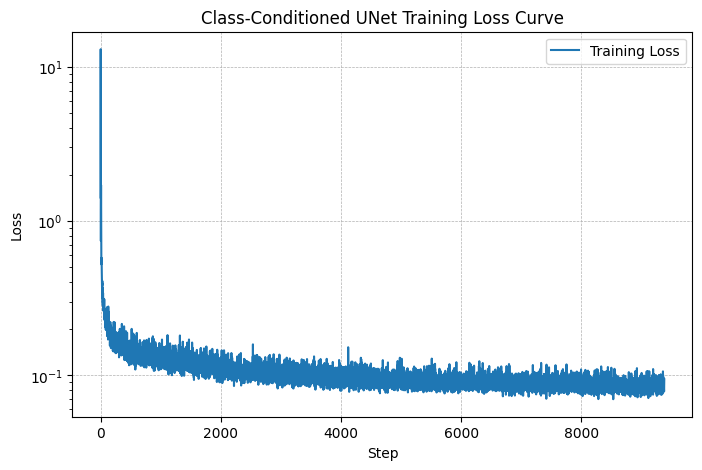

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", linewidth=1.5)
plt.yscale("log")  # Use log scale for better visualization
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Class-Conditioned UNet Training Loss Curve")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

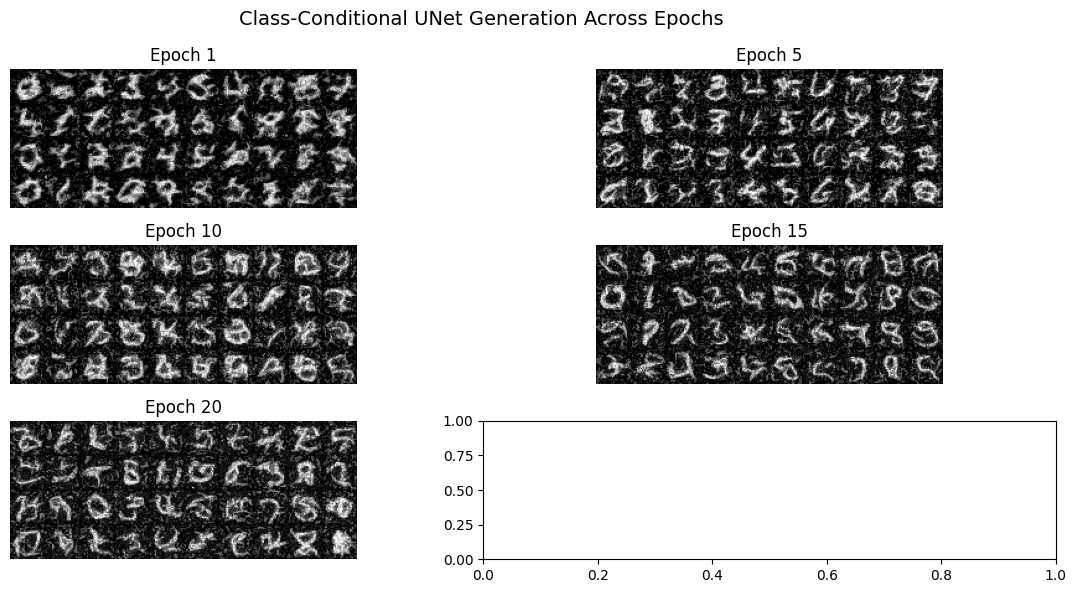

In [63]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Define checkpoint directory and epochs to visualize
checkpoint_dir = "./checkpoints_class_unet"
epochs_to_plot = [2, 5, 10, 15, 20]  # Epochs to visualize
num_samples = 40  # Number of images per epoch (4 rows of 10 digits each)
T = 200  # Number of timesteps in sampling

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)

# Define function for sampling class-conditional digits
def sample_images(T=50, class_labels=None):
    """Samples images from the model using class-conditional input."""
    N = len(class_labels)  # Number of samples (must match batch size)
    x_t = torch.randn((N, 1, 28, 28), device=device)  # Gaussian noise
    timesteps = torch.linspace(1.0, 0.0, steps=T, device=device)  # Time steps
    c = torch.tensor(class_labels, dtype=torch.int64, device=device)  # Class labels

    with torch.no_grad():
        for t in timesteps:
            t_tensor = torch.full((N, 1), t.item(), device=device)
            x_t = x_t + (1 / T) * model(x_t, c, t_tensor)  # Refinement step
    x_t = x_t.clamp(0, 1)
    return x_t.cpu().numpy() # Return as numpy array

# Create figure layout (one row per sampled epoch)
num_rows = 3  # Rows of images (each contains results from two epochs)
num_cols = 2  # Columns for side-by-side epoch comparisons
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Define a fixed digit ordering for visualization
digit_order = np.tile(np.arange(10), num_samples // 10)

# Generate and plot images for each epoch
for idx, epoch in enumerate(epochs_to_plot):
    checkpoint_path = os.path.join(checkpoint_dir, f"unet_epoch_{epoch}.pth")



    # Load model checkpoint
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    # Generate class-conditional digits
    generated_images = sample_images(T=T, class_labels=digit_order)

    # Arrange generated images in a grid of 4 rows × 10 columns
    grid_image = np.vstack([
        np.hstack(generated_images[i * 10:(i + 1) * 10, 0]) for i in range(4)
    ])

    row, col = divmod(idx, num_cols)  # Determine subplot location
    axes[row, col].imshow(grid_image, cmap="gray")
    if epoch == 2:
      axes[row, col].set_title(f"Epoch {epoch-1}")
    else:
      axes[row, col].set_title(f"Epoch {epoch}")
    axes[row, col].axis("off")

fig.suptitle("Class-Conditional UNet Generation Across Epochs", fontsize=14)
plt.tight_layout()
plt.show()
